# Main anaysis

### Setup

#### Imports

In [796]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game
from misc.util import save_plot

#### Overrides

In [797]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_pi=0.5",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.imprecise_imitation_alpha=0.5",
    "simulation.dynamics.max_its=1e5", # important to specify maxits
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


#### Helper function to filter data by config data

In [798]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_pi = df["meaning_dist_pi"] == curve_metadata.meaning_dist_pi

    imprecise_imitation_alpha = df["imprecise_imitation_alpha"].isin([curve_metadata.meaning_dist_pi, np.nan]) # allows curve, and constraints to be the same as curve.

    max_its = df["max_its"].isin([config.simulation.dynamics.max_its, np.nan]) # allows curve

    # temporary filtering
    not_binary = df["discriminative_need_gamma"] != 1e100

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_pi & imprecise_imitation_alpha & max_its & not_binary]

    return df_subsetted

#### Load data

In [799]:
all_data_fp = "../../analysis_data/all_data.csv"
df_all = pd.read_csv(all_data_fp)
df_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_69316/1129496392.py:2: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.


,run_num,iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,min_epsilon_index,...,eu_gamma=1.8738174228603868,eu_gamma=2.310129700083158,eu_gamma=2.848035868435805,eu_gamma=3.511191734215127,eu_gamma=4.328761281083061,eu_gamma=5.3366992312063015,eu_gamma=6.5793322465756825,eu_gamma=8.11130830789689,eu_gamma=10.0,eu_gamma=1e+100
0,0.0,3734.0,0.000001,0.000001,3.199885,1654.783057,1.0,0.000843,1.250845e-09,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,0.281837,0.072019,3.237316,1673.603978,1.0,0.370218,2.095223e-01,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,0.050169,0.040650,3.225527,1673.101459,1.0,0.094817,9.486669e-03,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,0.035042,0.031250,3.220544,1672.732027,1.0,0.068528,3.771451e-03,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,0.028473,0.026326,3.217649,1672.423861,1.0,0.056270,2.130624e-03,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292947,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.294524,0.273155,0.256964,0.245958,0.239426,0.236147,0.234807,0.23438,0.23428,0.234263
292948,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.294524,0.273155,0.256964,0.245958,0.239426,0.236147,0.234807,0.23438,0.23428,0.234263
292949,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.294524,0.273155,0.256964,0.245958,0.239426,0.236147,0.234807,0.23438,0.23428,0.234263
292950,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.294524,0.273155,0.256964,0.245958,0.239426,0.236147,0.234807,0.23438,0.23428,0.234263


In [800]:
print(list(df_all.columns))

['run_num', 'iteration', 'complexity', 'accuracy', 'distortion', 'mse', 'eu_gamma', 'kl_eb', 'min_epsilon', 'min_epsilon_index', 'min_epsilon_beta', 'min_epsilon_complexity', 'min_epsilon_accuracy', 'min_epsilon_distortion', 'min_epsilon_mse', 'min_epsilon_eu_gamma', 'min_epsilon_gnid', 'min_epsilon_nid', 'point_type', 'run', 'universe', 'prior', 'num_signals', 'distance', 'discriminative_need_gamma', 'meaning_dist_pi', 'dynamics', 'imprecise_imitation_alpha', 'population_init_tau', 'seed', 'max_its', 'did_converge', 'beta', 'eu_gamma=0.0', 'eu_gamma=1e-08', 'eu_gamma=1.2328467394420658e-08', 'eu_gamma=1.519911082952933e-08', 'eu_gamma=1.8738174228603828e-08', 'eu_gamma=2.310129700083158e-08', 'eu_gamma=2.848035868435805e-08', 'eu_gamma=3.511191734215127e-08', 'eu_gamma=4.328761281083062e-08', 'eu_gamma=5.3366992312063125e-08', 'eu_gamma=6.579332246575683e-08', 'eu_gamma=8.111308307896871e-08', 'eu_gamma=1e-07', 'eu_gamma=1.232846739442066e-07', 'eu_gamma=1.519911082952933e-07', 'eu_ga

#### Filter

In [801]:
df = get_df_subsetted_by_meaning_dists(df_all, config)
df

,run_num,iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,min_epsilon_index,...,eu_gamma=1.8738174228603868,eu_gamma=2.310129700083158,eu_gamma=2.848035868435805,eu_gamma=3.511191734215127,eu_gamma=4.328761281083061,eu_gamma=5.3366992312063015,eu_gamma=6.5793322465756825,eu_gamma=8.11130830789689,eu_gamma=10.0,eu_gamma=1e+100
0,0.0,3734.0,0.000001,0.000001,3.199885,1654.783057,1.0,0.000843,1.250845e-09,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,0.281837,0.072019,3.237316,1673.603978,1.0,0.370218,2.095223e-01,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,0.050169,0.040650,3.225527,1673.101459,1.0,0.094817,9.486669e-03,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,0.035042,0.031250,3.220544,1672.732027,1.0,0.068528,3.771451e-03,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,0.028473,0.026326,3.217649,1672.423861,1.0,0.056270,2.130624e-03,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292947,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.294524,0.273155,0.256964,0.245958,0.239426,0.236147,0.234807,0.23438,0.23428,0.234263
292948,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.294524,0.273155,0.256964,0.245958,0.239426,0.236147,0.234807,0.23438,0.23428,0.234263
292949,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.294524,0.273155,0.256964,0.245958,0.239426,0.236147,0.234807,0.23438,0.23428,0.234263
292950,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.294524,0.273155,0.256964,0.245958,0.239426,0.236147,0.234807,0.23438,0.23428,0.234263


In [802]:
df[df["meaning_dist_pi"] == 0.5].discriminative_need_gamma.value_counts()

discriminative_need_gamma
8.111308e-07    3208
1.232847e-03    3088
8.111308e-04    3078
2.310130e+00    3070
1.873817e+00    3070
                ... 
2.310130e-08    2452
1.873817e-08    2452
1.519911e-08    2452
1.232847e-08    2452
0.000000e+00    2452
Name: count, Length: 101, dtype: int64

Make sure seed is a discrete variable

In [803]:
df["seed"] = df["seed"].astype(str)

Separate out observations into curves and simulation points

In [804]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

Restrict dynamics

In [805]:
df_final_points = df_final_points[df_final_points["dynamics"] == "imprecise_conditional_imitation"]

How does discriminative_need_gamma range?

In [806]:
df_final_points.discriminative_need_gamma.unique()

array([0.00000000e+00, 1.00000000e-08, 1.23284674e-08, 1.51991108e-08,
       1.87381742e-08, 2.31012970e-08, 2.84803587e-08, 3.51119173e-08,
       4.32876128e-08, 5.33669923e-08, 6.57933225e-08, 8.11130831e-08,
       1.00000000e-07, 1.23284674e-07, 1.51991108e-07, 1.87381742e-07,
       2.31012970e-07, 2.84803587e-07, 3.51119173e-07, 4.32876128e-07,
       5.33669923e-07, 6.57933225e-07, 8.11130831e-07, 1.00000000e-06,
       1.23284674e-06, 1.51991108e-06, 1.87381742e-06, 2.31012970e-06,
       2.84803587e-06, 3.51119173e-06, 4.32876128e-06, 5.33669923e-06,
       6.57933225e-06, 8.11130831e-06, 1.00000000e-05, 1.23284674e-05,
       1.51991108e-05, 1.87381742e-05, 2.31012970e-05, 2.84803587e-05,
       3.51119173e-05, 4.32876128e-05, 5.33669923e-05, 6.57933225e-05,
       8.11130831e-05, 1.00000000e-04, 1.23284674e-04, 1.51991108e-04,
       1.87381742e-04, 2.31012970e-04, 2.84803587e-04, 3.51119173e-04,
       4.32876128e-04, 5.33669923e-04, 6.57933225e-04, 8.11130831e-04,
      

In [807]:
# How does seed range?
df_final_points.seed.unique()

array(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'],
      dtype=object)

In [808]:
# Remember, popuation_init_gamma is nan if we go with the simple uniform sampling init
df_final_points.population_init_tau.unique()

array([nan])

### Visualize

In [809]:
# Make sure complexity max is np.log2(100)
assert np.allclose(df_ib_bound.complexity.max(), np.log2(100))

#### First visualize all data, across initializations and seeds

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


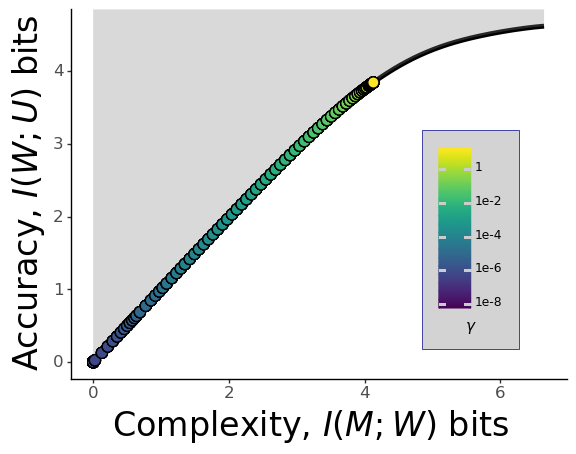

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


Saved a plot to figures/systems_on_bound.png


In [863]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=2) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            ),
        # alpha=0.3,
        size=4,
    )
    + pn.labs(fill="$\\gamma$")
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.4),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    )     

)
print(plot)
save_plot(
    "figures/systems_on_bound.png",
    plot,
)

In [811]:
# Converged results look a bit unevenly spread, dow many points do we have?
df_final_points.discriminative_need_gamma.value_counts()

discriminative_need_gamma
0.000000     8
0.005337     8
0.043288     8
0.035112     8
0.028480     8
            ..
0.000005     8
0.000004     8
0.000004     8
0.000003     8
10.000000    8
Name: count, Length: 101, dtype: int64

In [812]:
# Double check no min_epsilons are negative
df_final_points[df_final_points.min_epsilon < 0]

,run_num,iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,min_epsilon_index,...,eu_gamma=1.8738174228603868,eu_gamma=2.310129700083158,eu_gamma=2.848035868435805,eu_gamma=3.511191734215127,eu_gamma=4.328761281083061,eu_gamma=5.3366992312063015,eu_gamma=6.5793322465756825,eu_gamma=8.11130830789689,eu_gamma=10.0,eu_gamma=1e+100
80182,0.0,33225.0,0.577328,0.576542,3.885864,646.632705,0.996566,0.004236,-0.000003,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80551,0.0,42422.0,0.577328,0.576542,3.966602,646.632704,0.996566,0.004236,-0.000003,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80926,0.0,22913.0,0.577328,0.576542,4.158607,646.632705,0.996566,0.004236,-0.000003,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81283,0.0,31289.0,0.577328,0.576542,3.979501,646.632705,0.996566,0.004236,-0.000003,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81650,0.0,34927.0,0.577328,0.576542,3.979218,646.632705,0.996566,0.004236,-0.000003,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82019,0.0,29610.0,0.577328,0.576542,4.002347,646.632705,0.996566,0.004236,-0.000003,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82384,0.0,38542.0,0.577328,0.576542,4.200604,646.632705,0.996566,0.004236,-0.000003,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82757,0.0,21320.0,0.577328,0.576542,4.087117,646.632705,0.996566,0.004236,-0.000003,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83112,0.0,21379.0,0.609436,0.608578,3.988013,606.223448,0.996034,0.005971,-0.000005,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83467,0.0,17429.0,0.609436,0.608578,3.812239,606.223311,0.996034,0.005971,-0.000005,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Distribution of efficiency loss across converged emergent systems

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_density : Removed 24 rows containing non-finite values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/stat_density.py:218: RuntimeWarning: invalid value encountered in divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/stat_density.py:218: RuntimeWarning: invalid value encountered in divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/stat_density.py:218: RuntimeWarning: invalid value encountered in divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/stat_density.py:218: RuntimeWarning: invalid value encountered in divide
/Users/nathanielimel/miniforge3/envs/ibs

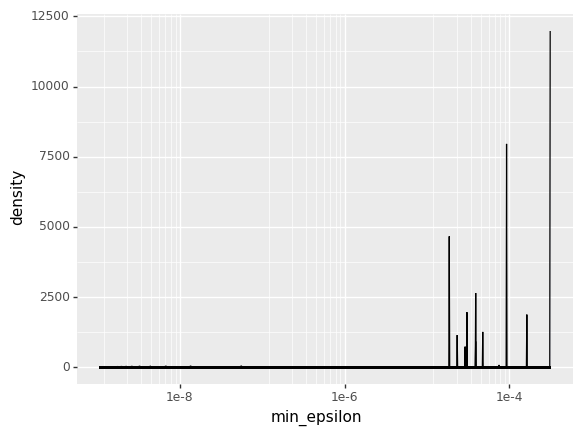

<ggplot: (1008226887)>

In [813]:
df_final_points_gamma_discrete = df_final_points.copy()
df_final_points_gamma_discrete["discriminative_need_gamma"] = df_final_points_gamma_discrete["discriminative_need_gamma"].astype(str)

(
    pn.ggplot(
        df_final_points_gamma_discrete,
        pn.aes(
            x="min_epsilon",
            # fill="seed",
            fill="discriminative_need_gamma",
        )
    )
    # + pn.scale_fill_manual(values = fill_values_dict)
    + pn.geom_density(alpha=0.3)
    # + pn.geom_histogram(binwidth=0.01)
    + pn.scale_x_log10()
    # + pn.facet_wrap("discriminative_need_gamma")
    + pn.theme(
        legend_position="none",
    )
)

# Okay, so for the first random seed I picked, the distribution of efficiency loss is highly peaked. This makes some sense, because if we look at the the trajectories, all colors appear to converge to the same respective points on y-axis.

#### How many did not converge?

In [814]:
df_final_points[df_final_points.did_converge == False].discriminative_need_gamma.value_counts()

discriminative_need_gamma
8.111308e-07    8
Name: count, dtype: int64

#### Trajectories of efficiency loss

Filter

In [896]:
gamma = 'discriminative_need_gamma'

df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["iteration"]
df_traj_analysis = df_traj_points.copy()


traj_analysis_columns = [
    gamma, 
    # "population_init_tau", # we don't use this anymore
    "seed", 
    "run_num",        
    "iteration",
    "did_converge",

    "complexity",
    "accuracy",
    "distortion",
    "mse",
    "eu_gamma",
    "kl_eb",

    "min_epsilon",
    "min_epsilon_index",
    "min_epsilon_beta",
    "min_epsilon_complexity",
    "min_epsilon_accuracy",
    "min_epsilon_distortion",
    "min_epsilon_mse",
    "min_epsilon_eu_gamma",
    "min_epsilon_gnid",  
    "min_epsilon_nid",

]
df_traj_analysis = df_traj_analysis[traj_analysis_columns]
df_traj_analysis

,discriminative_need_gamma,seed,run_num,iteration,did_converge,complexity,accuracy,distortion,mse,eu_gamma,...,min_epsilon,min_epsilon_index,min_epsilon_beta,min_epsilon_complexity,min_epsilon_accuracy,min_epsilon_distortion,min_epsilon_mse,min_epsilon_eu_gamma,min_epsilon_gnid,min_epsilon_nid
1,0.0,0.0,0.0,1.0,True,0.281837,0.072019,3.237316,1673.603978,1.000000,...,0.209522,26.0,1.001313,0.335066,0.334700,4.281711,1006.516699,1.000000,0.992175,0.999853
2,0.0,0.0,0.0,2.0,True,0.050169,0.040650,3.225527,1673.101459,1.000000,...,0.009487,16.0,1.000808,0.042878,0.042852,4.573559,1570.119827,1.000000,0.945176,0.999980
3,0.0,0.0,0.0,3.0,True,0.035042,0.031250,3.220544,1672.732027,1.000000,...,0.003771,14.0,1.000707,0.014768,0.014761,4.601649,1632.586879,1.000000,0.843013,0.999993
4,0.0,0.0,0.0,4.0,True,0.028473,0.026326,3.217649,1672.423861,1.000000,...,0.002131,13.0,1.000657,0.007567,0.007564,4.608846,1648.812577,1.000000,0.710899,0.999996
5,0.0,0.0,0.0,5.0,True,0.024604,0.023181,3.215702,1672.152749,1.000000,...,0.001409,13.0,1.000657,0.007567,0.007564,4.608846,1648.812577,1.000000,0.695784,0.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288110,10.0,3.0,0.0,57223.0,True,4.128355,3.843373,34.131284,5.807811,0.167877,...,0.000313,455.0,1.508040,4.127814,3.843327,0.773084,6.752322,0.155039,0.000387,0.444274
288111,10.0,3.0,0.0,61359.0,True,4.128355,3.843373,34.130646,5.807810,0.167877,...,0.000313,455.0,1.508040,4.127814,3.843327,0.773084,6.752322,0.155039,0.000387,0.444274
288112,10.0,3.0,0.0,65793.0,True,4.128355,3.843373,34.130501,5.807810,0.167877,...,0.000313,455.0,1.508040,4.127814,3.843327,0.773084,6.752322,0.155039,0.000387,0.444274
288113,10.0,3.0,0.0,70548.0,True,4.128355,3.843373,34.130775,5.807810,0.167877,...,0.000313,455.0,1.508040,4.127814,3.843327,0.773084,6.752322,0.155039,0.000387,0.444274


In [816]:
# Ensure iteration max is the same as max_its specified by game config
df_traj_analysis.iteration.max()

100000.0

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 733 rows containing missing values.


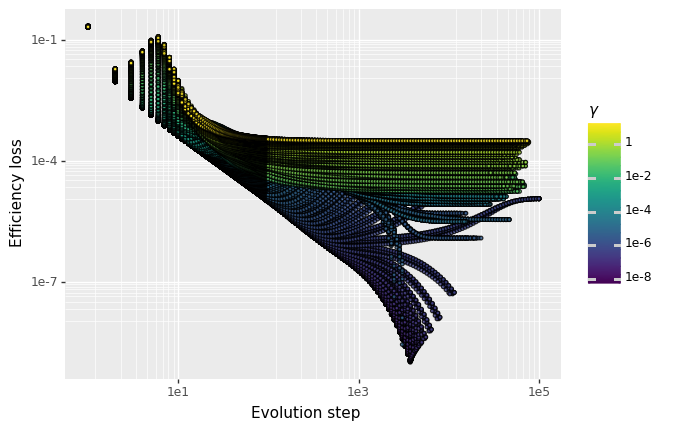

In [817]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_epsilon", 
            fill="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        # size=0.5,
        size=1,
        alpha=0.8,
        )
    # + pn.geom_line()
    + pn.labs(fill="$\\gamma$")    
    + pn.xlab("Evolution step")
    + pn.ylab("Efficiency loss")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    + pn.scale_fill_continuous(trans = 'log10')
    + pn.scale_x_log10()
)
print(plot)

Helper function to get mean and confidence intervals for a variable, grouped by gamma and iteration

In [881]:
from scipy import stats

# Calculate the mean and confidence intervals for each iteration
def mean_confidence_interval(data: pd.DataFrame, confidence=0.95) -> tuple[float]:
    mean, se = np.mean(data), stats.sem(data)
    interval = se * stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return (mean, mean - interval, mean + interval)

def mean_conf_df(trajectory_data: pd.DataFrame, colname: str, groupby_cols: list[str] = ['iteration', 'discriminative_need_gamma'],):
    df_summary = trajectory_data.groupby(groupby_cols)[colname].apply(mean_confidence_interval).apply(pd.Series)
    df_summary.columns = [f'mean_{colname}', 'lower_ci', 'upper_ci']
    df_summary = df_summary.reset_index()
    return df_summary


/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


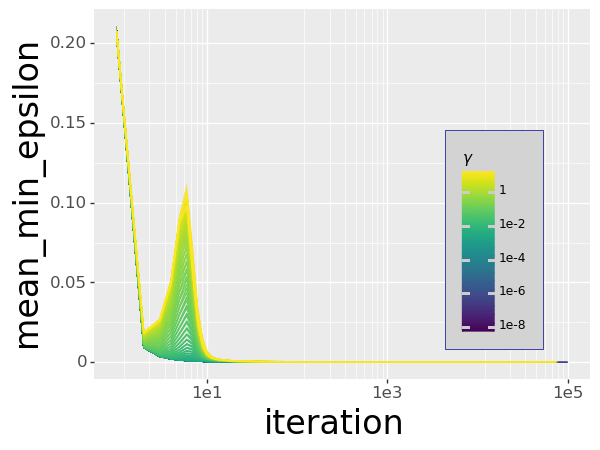

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


Saved a plot to figures/iterations_vs_min_epsilon.png


In [819]:
plot = (
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()

   + pn.labs(fill="$\\gamma$", color="$\\gamma$")
   + pn.theme(
      # Axis font
      axis_title=pn.element_text(size=24),
      axis_text=pn.element_text(size=12),
      # Legend position
      legend_position=(0.75, 0.4),
      # legend_position='none',
      legend_direction = "vertical",
      # Legend box
      legend_background=pn.element_rect(
         fill="lightgrey",
         size=0.5, linetype="solid", 
         color="darkblue",
      ),
   )
   # guide not working, maybe should just use R
   + pn.guides(
      fill = pn.guide_colorbar(
         title_position = "bottom", 
         label_position = "bottom",
         override_aes = {"alpha":0.8},
         ),
   )     

)
print(plot)
save_plot(
   "figures/iterations_vs_min_epsilon.png",
   plot,
)

#### Zoom in / Log scale

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10


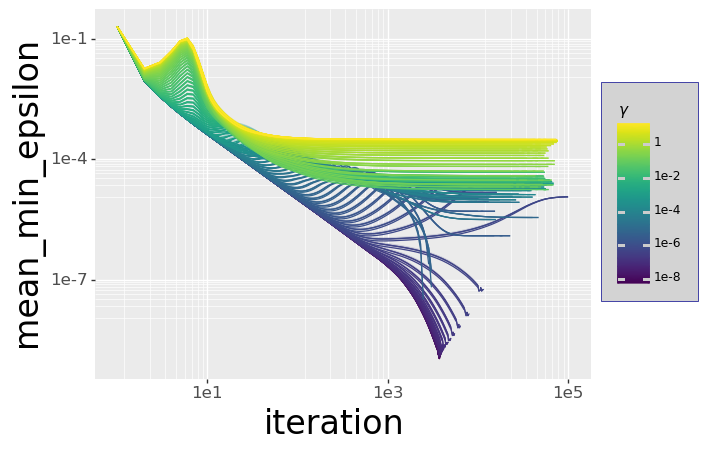

<ggplot: (820450701)>

In [906]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")  
   + pn.scale_y_log10() 
   + pn.scale_x_log10()
   # + pn.xlim(1e-4, 1e5)


   + pn.labs(fill="$\\gamma$", color="$\\gamma$")
   + pn.theme(
      # Axis font
      axis_title=pn.element_text(size=24),
      axis_text=pn.element_text(size=12),
      # Legend position
      # legend_position=(0.75, 0.4),
      # legend_position='none',
      legend_direction = "vertical",
      # Legend box
      legend_background=pn.element_rect(
         fill="lightgrey",
         size=0.5, linetype="solid", 
         color="darkblue",
      ),
   )
   # guide not working, maybe should just use R
   + pn.guides(
      fill = pn.guide_colorbar(
         title_position = "bottom", 
         label_position = "bottom",
         override_aes = {"alpha":0.8},
         ),
   )

)

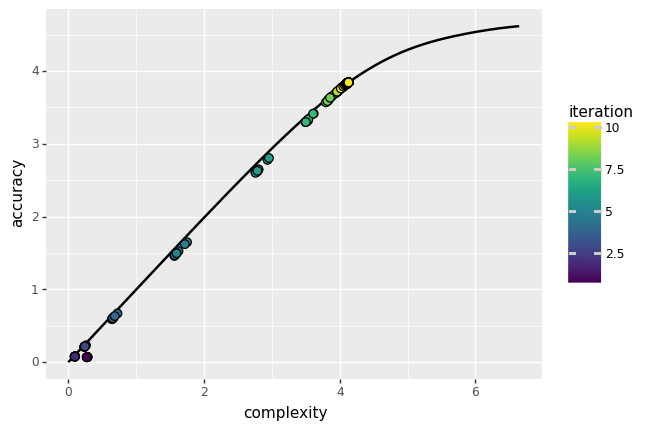

<ggplot: (816423432)>

In [821]:
# I'm so curious to see if we can see this on the trajectories. Zoom in on gamma=1000

df_traj_gamma_3 = df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == np.max(df_traj_analysis["discriminative_need_gamma"])]

(
    pn.ggplot(
        df_traj_gamma_3,
        pn.aes(
            x="complexity",
            y="accuracy",
            # color="iteration",
            # size="iteration",
            # color="discriminative_need_gamma",
        ),
    )
    # + pn.scale_size_continuous( limits=[1,5])    
    + pn.geom_line(df_ib_bound, size=1, color="black")
    + pn.geom_point(
        pn.aes(
            fill="iteration",
        ),
        size=3,        
    )
    + pn.scale_fill_continuous( 
        limits=[1,10]
    )


    # + pn.ylim(0,3)
    # + pn.xlim(0,3)
    # + pn.facet_wrap("discriminative_need_gamma")
)

#### Visualize comp vs. EU

together?

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


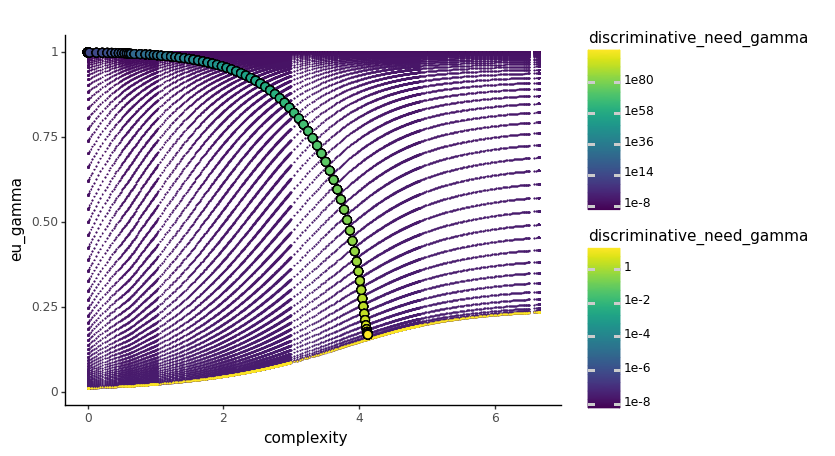

<ggplot: (810996355)>

In [823]:
# I'd like to know what the IB curves achieve in terms of their EU.

eu_cols = [colname for colname in df_ib_bound.columns if "eu_gamma=" in colname]
cols = ["complexity", "accuracy",] + eu_cols


df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)

# Yet another bandaid for string parsing the 0.5 width.

df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1]).astype(float)


(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.geom_point(shape="+", size=0.25,)

    # Now the simulation data
    + pn.geom_point(
        df_final_points,
        pn.aes(
            fill="discriminative_need_gamma",
        ),
        shape="o",
        color="black",
        size=3,
    )
    + pn.scale_color_continuous(trans = "log10")
    + pn.scale_fill_continuous(trans = "log10")    

    # + pn.ylim(0, 0.25)
    + pn.theme_classic()
)

#### Plot complexity vs. mse for each emergent system and its fitted counterpart.

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1197 rows containing missing values.


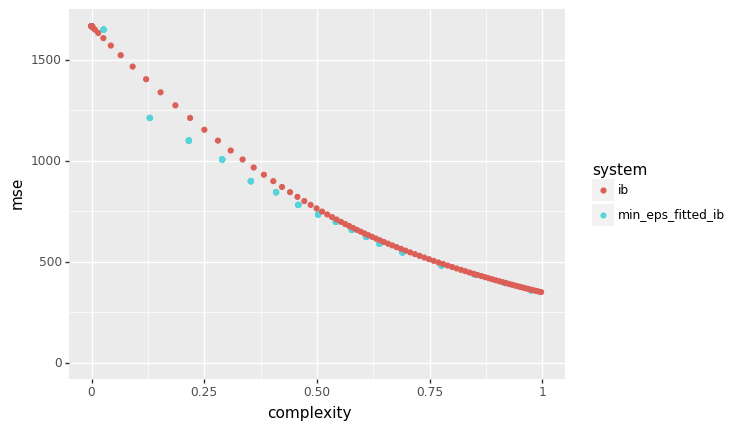

<ggplot: (891561747)>

In [860]:
df_emergent = df_final_points[["complexity", "mse", "discriminative_need_gamma"]].copy()
df_emergent["system"] = "emergent"

df_fitted_optima = df_final_points[["complexity", "min_epsilon_mse", "discriminative_need_gamma"]]
df_fitted_optima["system"] = "min_eps_fitted_ib"
df_fitted_optima["mse"] = df_fitted_optima["min_epsilon_mse"]

df_all_optima = df_ib_bound[["complexity", "mse"]].copy()
df_all_optima["system"] = "ib"

df_compare = pd.concat([
    # df_emergent, 
    df_fitted_optima,
    df_all_optima,
])

(
    pn.ggplot(
        df_compare,
        pn.aes(
            x="complexity",
            y="mse",
            color="system",
        )
    )
    + pn.geom_point()
    # + pn.geom_line()
    + pn.xlim(0,1)
    # + pn.ylim(0,10)
    # + pn.ylim(500, 1500)
    # + pn.scale_y_log10()
)

#### TODO: why can the min_eps_fitted ib systems achieve lower mse than ib? they should coincide perfectly.

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


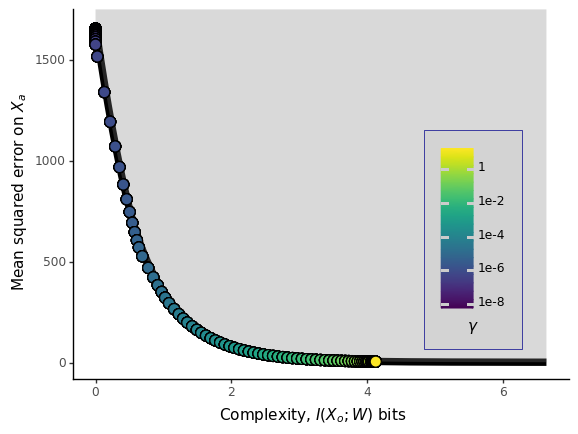

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


Saved a plot to figures/systems_on_bound_mse.png


In [824]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="mse")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="mse",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # shape="seed",
            ),
        # alpha=0.3,
        size=4,
    )
    + pn.labs(fill="$\\gamma$")
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(X_o;W)$ bits")
    + pn.ylab("Mean squared error on $X_a$")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        # axis_title=pn.element_text(size=24),
        # axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.4),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    )     

)
print(plot)
save_plot(
    "figures/systems_on_bound_mse.png",
    plot,
)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


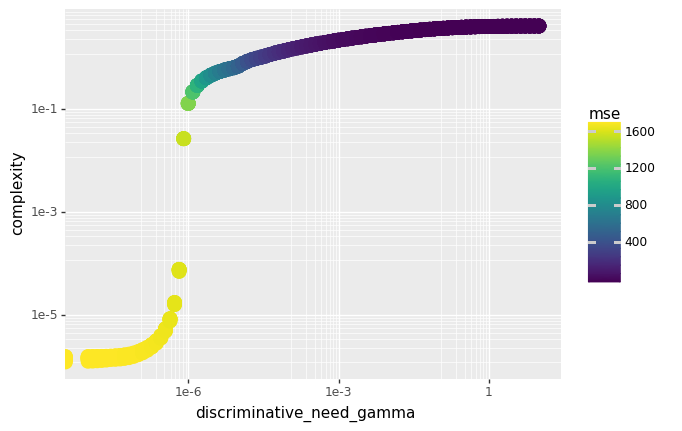

<ggplot: (1003944024)>

In [825]:
(
    pn.ggplot(
        df_final_points,
        pn.aes(
            x="discriminative_need_gamma",
            y="complexity",
            color="mse",
        )
    )
    + pn.geom_point(size=5)
    + pn.scale_x_log10()
    # + pn.xlim(1e-7, 1e1)
    + pn.scale_y_log10()
)

In [826]:
# what is the first gamma that yields 0 complexity?
# probably 1e-8, based on the plot above. We'll add a 0 gamma system too.

In [827]:
# what is the first gamma that yields max complexity
df_final_points[df_final_points.complexity == df_final_points.complexity.max()].discriminative_need_gamma

gms = sorted(df_final_points.discriminative_need_gamma.unique())
df_final_points[df_final_points.discriminative_need_gamma == gms[-5]]

# Looks like 1e10 is a good choice for upper bound besides 1e100

,run_num,iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,min_epsilon_index,...,eu_gamma=1.8738174228603868,eu_gamma=2.310129700083158,eu_gamma=2.848035868435805,eu_gamma=3.511191734215127,eu_gamma=4.328761281083061,eu_gamma=5.3366992312063015,eu_gamma=6.5793322465756825,eu_gamma=8.11130830789689,eu_gamma=10.0,eu_gamma=1e+100
273054,0.0,75592.0,4.124044,3.840520,34.186006,5.830839,0.171532,0.053237,0.000308,455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273445,0.0,63575.0,4.124043,3.840519,34.215587,5.830847,0.171532,0.053237,0.000308,455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273832,0.0,52064.0,4.124046,3.840521,35.880971,5.830835,0.171532,0.053237,0.000308,455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274213,0.0,46356.0,4.124045,3.840520,33.737803,5.830838,0.171532,0.053237,0.000308,455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274590,0.0,37622.0,4.124044,3.840520,34.802020,5.830840,0.171532,0.053237,0.000308,455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274961,0.0,47334.0,4.124045,3.840521,36.032606,5.830835,0.171532,0.053237,0.000308,455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275340,0.0,51038.0,4.124045,3.840521,35.550859,5.830836,0.171532,0.053237,0.000308,455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275721,0.0,59268.0,4.124044,3.840520,32.564296,5.830842,0.171532,0.053237,0.000308,455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


complexity vs beta with utility as color (heatmap)?


In [828]:
# Sanity check that a bijective sender and bayesian receiver team will achieve at most 0.25 expected utility in the highest gamma game, because of the meaning confusion probabilities

game = Game.from_hydra(config)

encoder = np.eye(len(game.universe))
# decoder = encoder.T # not nec. ib
decoder = (encoder * game.prior[:, None]) / (encoder.T @ game.prior) @ game.meaning_dists

optimal_team = optimal_team = game.meaning_dists @ encoder @ decoder @ game.meaning_dists
high_gamma_utility = np.eye(len(game.universe))

# expected utility
np.sum(game.prior * (optimal_team * high_gamma_utility))

0.2342627097867039

In [829]:
# check that without confusion we achieve 1.0 utility
np.sum(game.prior * (np.eye(len(game.universe)) * game.utility))

1.0

is it possible to view trajectories too? yes.

How to read the below plot: lines are ib optima, circles are trajectories of emergent systems.

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 374 rows containing missing values.


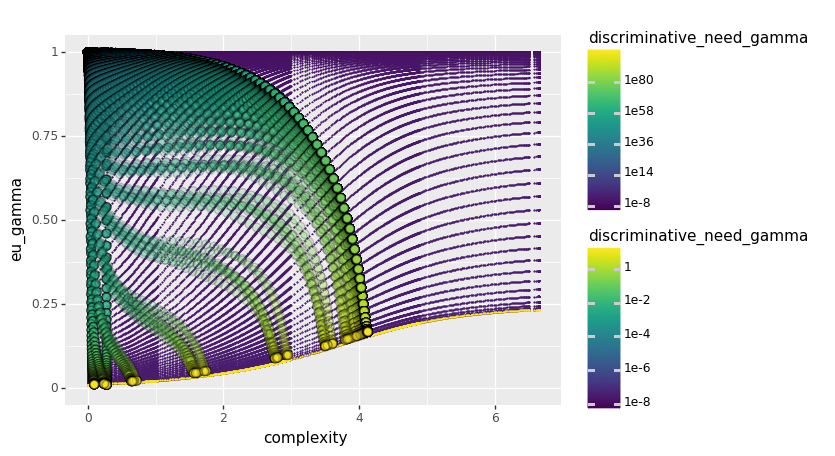

<ggplot: (862156389)>

In [830]:
df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)
df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1]).astype(float)

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_continuous(trans = "log10")

    + pn.geom_point(
        shape="+", 
        size=0.25,
    )

    # Now the simulation data
    + pn.geom_point(
        data=df_traj_analysis, # why does the highest gamma always get overplotted? maybe we should drop anyway...
        mapping=pn.aes(
            # size="iteration",
            fill="discriminative_need_gamma",
        ),
        shape="o",
        size=3,
        alpha=0.2,
        color="black",
    )
    + pn.scale_fill_continuous(trans = "log10")
    + pn.ylim(0,1)
)

#### Visualize kl_eb over time

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


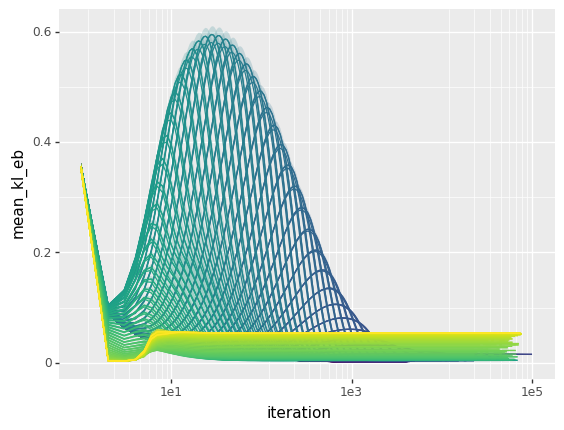

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


Saved a plot to figures/iterations_vs_KL_R_R_bayes.png


In [831]:
plot = (
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "kl_eb"),
      pn.aes(
         x="iteration",
         y="mean_kl_eb",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()

   + pn.theme(
       legend_position="none",
   )


)
print(plot)
save_plot(
   "figures/iterations_vs_KL_R_R_bayes.png",
   plot,
)

#### The above figure is too busy, just look at the converged systems.

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


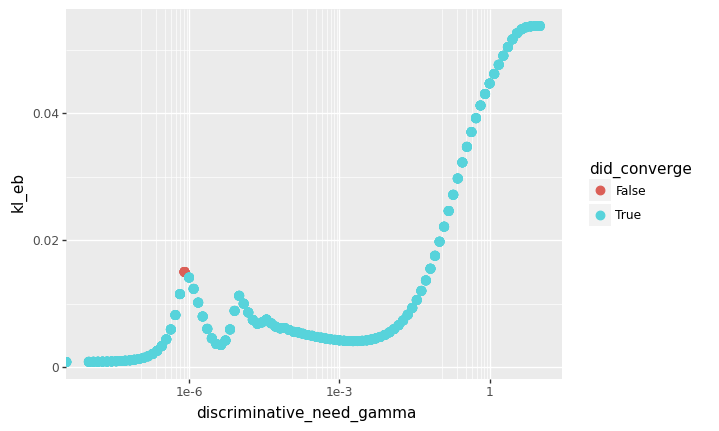

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


Saved a plot to figures/converged_vs_KL_R_R_bayes.png


In [891]:
plot = (
   pn.ggplot(
      df_final_points,
      pn.aes(
         x="discriminative_need_gamma",
         y="kl_eb",
         color="did_converge",
      )
   )

    + pn.geom_point(
        size=3,
    )
    + pn.scale_x_log10()

)
print(plot)
save_plot(
   "figures/converged_vs_KL_R_R_bayes.png",
   plot,
)

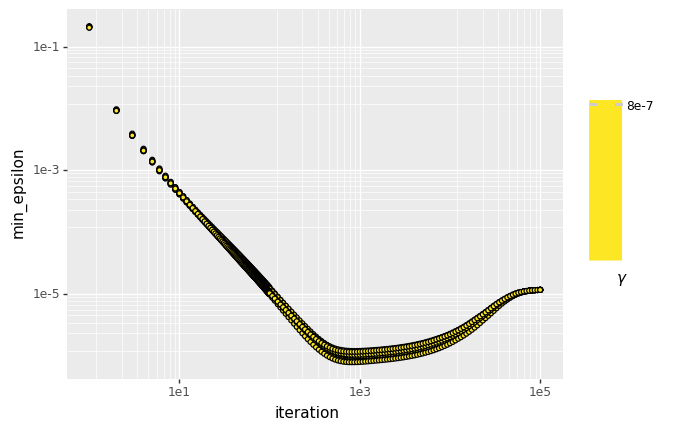

<ggplot: (1002017504)>

In [902]:
# Let's take a closer look at those non-converged systems.

df_non_converged = df_traj_analysis[df_traj_analysis["did_converge"] == False]

(
    
   pn.ggplot(
      df_non_converged,
      pn.aes(
         x="iteration",
         y="min_epsilon",
         fill="discriminative_need_gamma",
      )
   )
   + pn.geom_point()
   # + pn.geom_line()

   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()

   + pn.labs(fill="$\\gamma$", color="$\\gamma$")

   # guide not working, maybe should just use R
   + pn.guides(
      fill = pn.guide_colorbar(
         title_position = "bottom", 
         label_position = "bottom",
         override_aes = {"alpha":0.8},
         ),
   )     
)

#### TODO: I need to look more carefully at the assertion that min_epsilon really does decrease over time.

In [884]:
mean_conf_df(df_final_points, "kl_eb", ["discriminative_need_gamma"])

,discriminative_need_gamma,mean_kl_eb,lower_ci,upper_ci
0,0.000000e+00,0.000843,0.000843,0.000843
1,1.000000e-08,0.000871,0.000871,0.000871
2,1.232847e-08,0.000878,0.000878,0.000878
3,1.519911e-08,0.000887,0.000887,0.000887
4,1.873817e-08,0.000899,0.000899,0.000899
...,...,...,...,...
96,4.328761e+00,0.053237,0.053237,0.053237
97,5.336699e+00,0.053567,0.053567,0.053567
98,6.579332e+00,0.053706,0.053706,0.053706
99,8.111308e+00,0.053751,0.053751,0.053751


/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


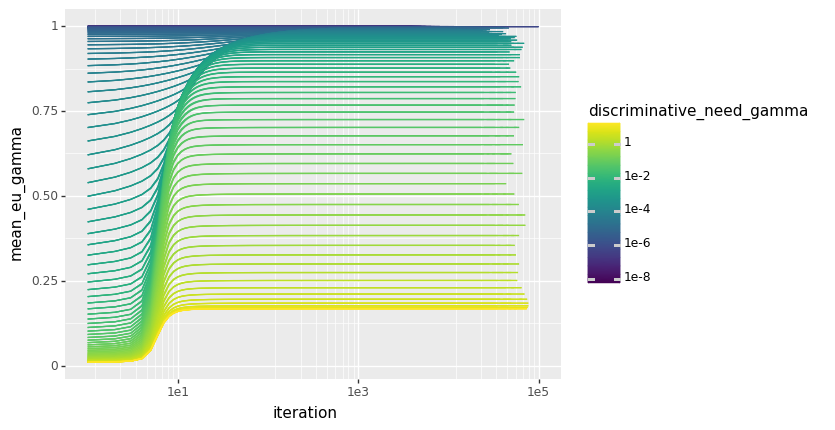

<ggplot: (981669018)>

In [833]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "eu_gamma"),
      pn.aes(
         x="iteration",
         y="mean_eu_gamma",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


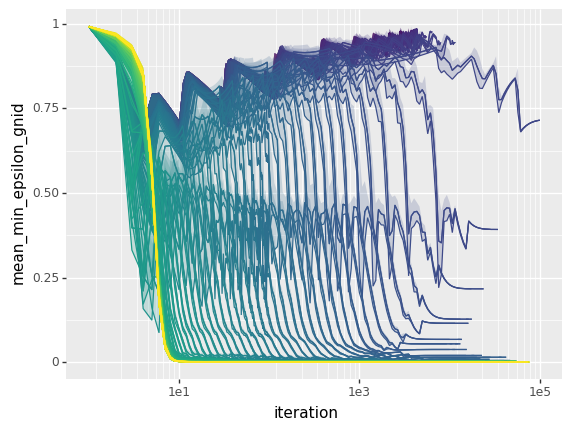

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


Saved a plot to figures/iterations_vs_min_gNID.png


In [865]:
mean_min_gnid_df = mean_conf_df(df_traj_analysis, "min_epsilon_gnid")

plot = (
   pn.ggplot(
      mean_min_gnid_df,
      pn.aes(
         x="iteration",
         y="mean_min_epsilon_gnid",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
   + pn.theme(
       legend_position="none",
   )

)
print(plot)
save_plot(
   "figures/iterations_vs_min_gNID.png",
   plot,
)

### gNID, NID (dissimilarity measures)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


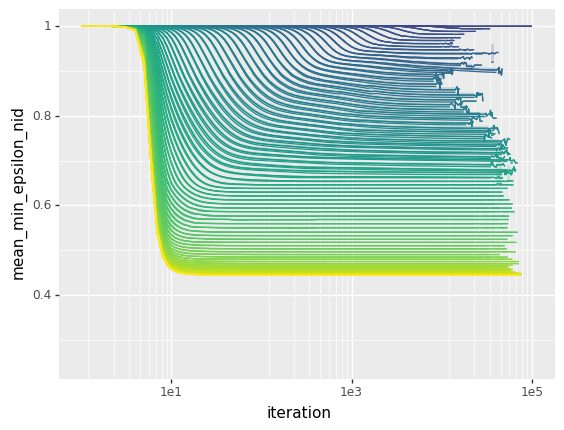

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


Saved a plot to figures/iterations_vs_min_NID.png


In [869]:
mean_min_nid_df = mean_conf_df(df_traj_analysis, "min_epsilon_nid")

plot = (
   pn.ggplot(
      mean_min_nid_df,
      pn.aes(
         x="iteration",
         y="mean_min_epsilon_nid",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
   + pn.theme(
       legend_position="none",
   )
   + pn.ylim(0.25,1)

)
print(plot)
save_plot(
   "figures/iterations_vs_min_NID.png",
   plot,
)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


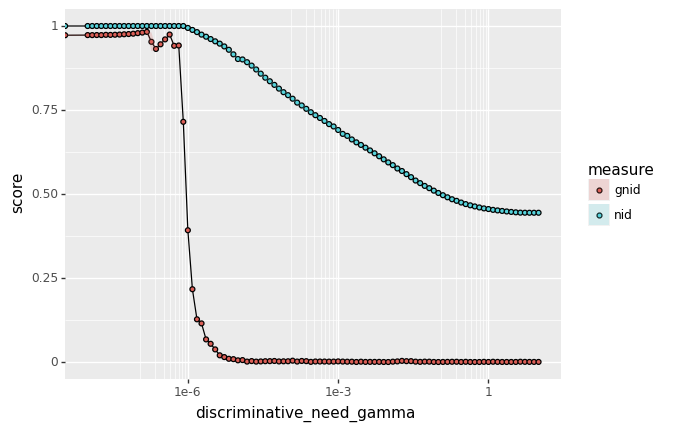

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


Saved a plot to figures/converged_gamma_vs_min_NID_gNID.png


In [922]:
mean_min_nid_df = mean_conf_df(df_final_points, "min_epsilon_nid", ["discriminative_need_gamma"])
mean_min_gnid_df = mean_conf_df(df_final_points, "min_epsilon_gnid", ["discriminative_need_gamma"])

mean_min_nid_df["measure"] = "nid"
mean_min_nid_df["score"] = mean_min_nid_df.mean_min_epsilon_nid
mean_min_gnid_df["measure"] = "gnid"
mean_min_gnid_df["score"] = mean_min_gnid_df.mean_min_epsilon_gnid
mean_dissim_df = pd.concat([mean_min_nid_df, mean_min_gnid_df])

plot = (
   pn.ggplot(
      mean_dissim_df,
      pn.aes(
         x="discriminative_need_gamma",
         y="score",
         group="measure",
         fill="measure",
      )
   )
   + pn.geom_line()
   + pn.geom_point(size=2)
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         # fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_x_log10()

   + pn.theme(
      #  legend_position="none",
   )

)
print(plot)
save_plot(
   "figures/converged_gamma_vs_min_NID_gNID.png",
   plot,
)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


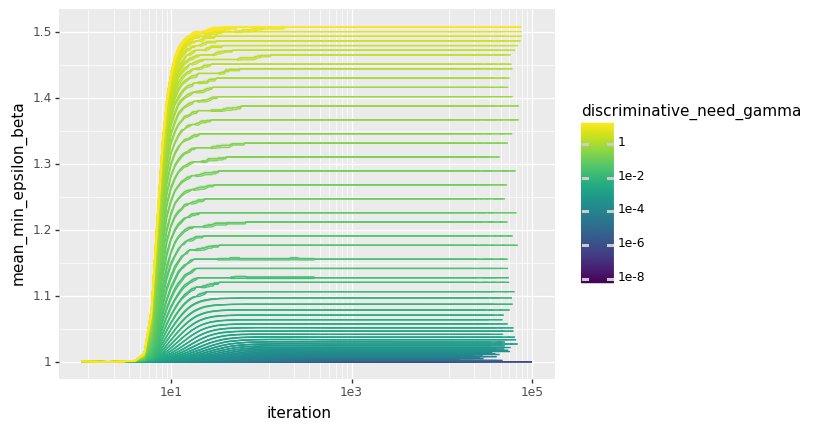

<ggplot: (1002044732)>

In [867]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon_beta"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon_beta",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
)